In [1]:
import os
import pickle
import numpy as np
from pydrake.all import (#PiecewisePolynomial, 
                        #InverseKinematics, 
                        HPolyhedron,
                        Sphere, 
                        Cylinder,
                        Rgba, 
                        RigidTransform, 
                        RotationMatrix, 
                        #IrisInConfigurationSpace, 
                        RollPitchYaw,
                        StartMeshcat,
                        MeshcatVisualizerParams,
                        MeshcatVisualizer,
                        Role,
                        TriangleSurfaceMesh,
                        SurfaceTriangle,
                        IrisOptions
                        )
from functools import partial
import numpy as np
from pydrake.all import SceneGraphCollisionChecker
from region_generation import SNOPT_IRIS_obstacles_simple
from visibility_utils import (get_col_func, 
                              get_sample_cfree_handle,
                              get_coverage_estimator,
                              point_in_regions,
                              vgraph
                              )
from ur3e_demo import UrDiagram, SetDiffuse
import pydrake
import ipywidgets as widgets
from environments import get_environment_builder

/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

add_shelf = True
seed = 1
np.random.seed(seed)

plant_builder = get_environment_builder('6DOFUR5')
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder(True)
robot_instances = [plant.GetModelInstanceByName("ur0"), plant.GetModelInstanceByName("schunk0")]
step_size = 0.125
checker = SceneGraphCollisionChecker(model = diagram, 
                robot_model_instances = robot_instances,
                distance_function_weights =  [1] * plant.num_positions(),
                #configuration_distance_function = _configuration_distance,
                edge_step_size = step_size)

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) 
q_min = plant.GetPositionLowerLimits()*scaler
q_max =  plant.GetPositionUpperLimits()*scaler

col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)
estimate_coverage = get_coverage_estimator(sample_cfree, pts = 5000)
vgraph_handle = partial(vgraph, checker = checker, parallelize = True) 


INFO:drake:Meshcat listening for connections at http://localhost:7000
INFO:drake:Allocating contexts to support 20 parallel queries given omp_num_threads 20 omp_max_threads 20 and omp_thread_limit 2147483647 OpenMP enabled in build? true


http://localhost:7000


In [3]:
query = scene_graph.get_query_output_port().Eval(scene_graph.GetMyContextFromRoot(diagram_context))
inspector = query.inspector()
a = inspector.GetCollisionCandidates()
geomids= []
for b, c in a:
    geomids.append(b)
    geomids.append(c)
ids = list(set(inspector.GetAllGeometryIds()))
frame_id_dict = {}
for idx in range(len(ids)):
    #print(idx, plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])))
    fr_id = inspector.GetFrameId(ids[idx])
    body = plant.GetBodyFromFrameId(fr_id)
    if body is not None:
        if  body.name() =='body':
            frame_id_dict['body'] = ids[idx]
        if  body.name() =='left_finger':
            frame_id_dict['left_finger'] = ids[idx]
        if  body.name() =='right_finger':
            frame_id_dict['right_finger'] = ids[idx]
        if  body.name() =='ur_wrist_3_link':
            frame_id_dict['ur_wrist_3_link'] = ids[idx]
        if  body.name() =='ur_wrist_2_link':
            frame_id_dict['ur_wrist_2_link'] = ids[idx]

print(frame_id_dict)
geom_ids = [inspector.GetGeometries(inspector.GetFrameId(frame_id_dict[k]))[0] for k in ['ur_wrist_2_link','ur_wrist_3_link','body', 'left_finger', 'right_finger']]

sh_frames = [6,7, 11,12,13]
sh_geom = [inspector.GetShape(id) for id in geom_ids] 
sh_names = ['ur_wrist_2_link','ur_wrist_3_link', 'box', 'l','r']

def plot_endeff_pose(q2, name = '', color = Rgba(1,1,0.1,0.8)):
    plant.SetPositions(plant_context, q2.reshape(-1,1))
    tfs = [ plant.EvalBodyPoseInWorld(plant_context,  plant.get_body(pydrake.multibody.tree.BodyIndex(fr))) for fr in sh_frames]
    for n, f, geom in zip(sh_names[2:], tfs[2:], sh_geom[2:]):
        #print(n,f,geom)
         meshcat.SetObject("/iris/shunk/"+name+"/"+n,
                                geom,
                                color)
         meshcat.SetTransform("/iris/shunk/"+name+"/"+n, f)
# for i,p in enumerate(poi):
#     plot_endeff_pose(p, str(i))

def show_ik_target(pose, meshcat, name):
    h = 0.2
    if 'targ' in name:
        colors = [Rgba(1,0.5,0, 0.5), Rgba(0.5,1,0, 0.5), Rgba(0.0,0.5,1, 0.5)]
    else:
        colors = [Rgba(1,0,0, 1), Rgba(0.,1,0, 1), Rgba(0.0,0.0,1, 1)]

    rot = pose.rotation()@RotationMatrix.MakeYRotation(np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([h/2, 0,0])
    meshcat.SetObject(f"/drake/ik_target{name}/triad1",
                                   Cylinder(0.01,0.2),
                                   colors[0])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad1",RigidTransform(rot, pos))
    rot = pose.rotation()@RotationMatrix.MakeXRotation(-np.pi/2)
    pos= pose.translation() +pose.rotation()@np.array([0,h/2,0])

    meshcat.SetObject(f"/drake/ik_target{name}/triad2",
                                   Cylinder(0.01,0.2),
                                   colors[1])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad2",RigidTransform(rot, pos))
    pos= pose.translation().copy()
    rot = pose.rotation()
    pos = pos + rot@np.array([0,0,h/2])
    meshcat.SetObject(f"/drake/ik_target{name}/triad3",
                                   Cylinder(0.01,0.2),
                                   colors[2])
    meshcat.SetTransform(f"/drake/ik_target{name}/triad3",RigidTransform(rot, pos))

def densify_waypoints(waypoints_q, densify = 200):
    #densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            plant.SetPositions(plant_context, qa)
            tf_tot=  plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot=  tf =plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName('body'))
        tf = tf_tot.translation()+tf_tot.rotation()@np.array([0,0.1,0])

        meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        meshcat.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
        

def anim_endeff_traj(dense_waypoints, anim, frame):
    #color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot=  plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName('body'))
        tf = tf_tot.translation()+tf_tot.rotation()@np.array([0,0.1,0])

        #  meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
        #                        Sphere(0.005),
        #                        color)

        anim.SetTransform(frame,f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(tf_tot.rotation(),
                                                  tf))

def prepare_traj_plotting():
    color = Rgba(1,0,0,1.0)
    for idx in range(300):
        meshcat.SetObject(f"/iris/points/traj/{idx}",
                                Sphere(0.01),
                                color)

prepare_traj_plotting()  
def hide_traj(name, anim, frame):
    for i in range(300):
        anim.SetTransform(frame,name + str(i), RigidTransform(
                            RotationMatrix(), 
                            np.array([0,0,1000])))
        
def show_pose(qvis, plant, plant_context, diagram, diagram_context, endeff_frame, show_body_frame = None):
    plant.SetPositions(plant_context, qvis)
    diagram.ForcedPublish(diagram_context)
    tf =plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName(endeff_frame))
    transl = tf.translation()+tf.rotation()@np.array([0,0.1,0])
    if show_body_frame is not None:
        show_body_frame(RigidTransform(tf.rotation(), transl))

show_body_frame = partial(show_ik_target, 
                          meshcat=meshcat, 
                          name='endeff_actual', 
                          )
showres = partial(show_pose, 
                  plant = plant, 
                  plant_context = plant_context, 
                  diagram = diagram, 
                  diagram_context = diagram_context,
                  endeff_frame = 'body',
                  show_body_frame=show_body_frame)

q = np.zeros(plant.num_positions()) 
sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
for slider in sliders:
    display(slider)

{'ur_wrist_2_link': <GeometryId value=66>, 'ur_wrist_3_link': <GeometryId value=70>, 'body': <GeometryId value=79>, 'left_finger': <GeometryId value=85>, 'right_finger': <GeometryId value=91>}


FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q1', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q2', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q3', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q4', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q5', max=2.827433388230814, min=-2.827433388230814)

In [7]:
showres(np.array([ 0.07257, -2.42743,  1.17257, -1.92743, -1.52743, 0]))
qvis = np.array([ 0.07257, -2.42743,  1.17257, -1.92743, -1.52743, 0])

In [4]:
from task_space_seeding_utils import (get_cvx_hulls_of_bodies,
                                      get_AABB_cvxhull,
                                      task_space_sampler_mp,
                                      task_space_sampler)

In [5]:
geom_names = [ 'shelves_body']
model_names = [ 'shelves']
default_pos = [np.array([ 0.07257, -2.42743,  1.17257, -1.92743, -1.52743, 0]),
               ]
approach_dir = [0]
approach_sign = [-1] 

In [6]:
from pydrake.all import VPolytope, HPolyhedron
from visualization_utils import plot_regions, plot_points
from visibility_utils import generate_distinct_colors
import time

offset_size = -0.05

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)
cols = generate_distinct_colors(2*len(model_names), rgb = True)[1:]
#cols = [list(c)+[1] for c in cols]
AABB_sampling_regions = []
ts_samplers = []
for i, (g, m) in enumerate(zip(geom_names, model_names)):
    cvx_hulls_of_ROI_unsc, bodies = get_cvx_hulls_of_bodies([g], [m], plant, scene_graph, scene_graph_context, scaling = 1.0)
    verts = [VPolytope(c).vertices().T for c in cvx_hulls_of_ROI_unsc]
    cvx_hulls_of_ROI = cvx_hulls_of_ROI_unsc
    cvx_hulls_of_ROI = []
    for v in verts:
        offset = approach_sign[i]*(np.sign(v[:,approach_dir[i]] - np.mean(v[:,approach_dir[i]]))==approach_sign[i])*offset_size
        v[:,approach_dir[i]] += offset #scale*(v[:,approach_dir[i]] - np.mean(v[:,approach_dir[i]])) +  np.mean(v[:,approach_dir[i]])
        cvx_hulls_of_ROI.append(HPolyhedron(VPolytope(v.T)))
    ts_min, ts_max, cvxh_hpoly = get_AABB_cvxhull(cvx_hulls_of_ROI)
    AABB_sampling_regions.append([ts_min, ts_max])
    plot_regions(meshcat, cvx_hulls_of_ROI, region_suffix=m,opacity=0.2, colors=[cols[i]])
    q0  = default_pos[i] #np.zeros(7)
    plant.SetPositions(plant_context, q0)
    plant.ForcedPublish(plant_context)
    showres(q0)
    t0 = plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName("body")).translation()       
    sample_handle_ts = partial(task_space_sampler_mp,
                            q0 = q0,
                            t0 = t0,
                            plant_builder = plant_builder,
                            frame_names = ['body'],
                            offsets = [np.array([0,0.1,0])],
                            cvx_hulls_of_ROI =cvx_hulls_of_ROI,
                            ts_min = ts_min,
                            ts_max = ts_max,
                            collision_free = True,
                            track_orientation = False,
                            axis_alignment = None#approach_dir[i]
                            )
    ts_samplers.append(sample_handle_ts)

In [7]:
Npts = 10
if f"6dof_ur3_{Npts}_{offset_size}_{seed}.pkl" in os.listdir('tmp'):
    with open(f"tmp/6dof_ur3_{Npts}_{offset_size}_{seed}.pkl", 'rb') as f:
        d = pickle.load(f)
        q_obj = d['q_obj']
        t_obj = d['t_obj']
        ad_mat = d['ad_obj']
else:
    q_obj = []
    t_obj = []
    ad_obj = []
    for sh in ts_samplers:
        q, t, _, res = sh(Npts,[])
        ad_mat = vgraph_handle(q)
        q_obj +=[q]
        t_obj +=[t]
        ad_obj +=[ad_obj]
    with open(f"tmp/6dof_ur3_{Npts}_{offset_size}_{seed}.pkl", 'wb') as f:
        pickle.dump({'q_obj':q_obj, 't_obj':t_obj, 'ad_obj': ad_obj}, f)


100%|██████████| 50/50 [01:21<00:00,  1.62s/it]


##### STATS ON CLUSTERS #####
cliques: 15
clusters: 2
mean cluster size: 500.0
mean clique size: 44.93333333333333
max clique size: 141
min clique size: 13
clique sizes: [141, 114, 74, 67, 65, 39, 34, 27, 23, 15, 13, 13, 13, 23, 13]


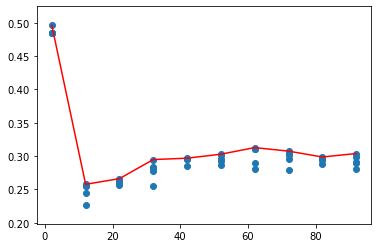

In [8]:
#cluster points
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from clique_covers import compute_greedy_clique_partition

silhouette_method_steps = 10
min_clique_size = 10
kmeans_trials = 5

cliques_obj = []
num_clusters_obj = []
cluster_sizes_obj = []
for i, (q, t) in enumerate(zip(q_obj, t_obj)):
    q_regularized = (q - np.mean(q, axis = 0))/np.std(q, axis = 0)
    sil = []
    kmsol = []
    min_k = 2#[5,5, 5]
    max_k = int(np.ceil(Npts/min_clique_size))#[20, 20, 100 ]
    clus_vals = np.arange(min_k,max_k, silhouette_method_steps)
    clus_vals_trials = []
    mean_sil = []
    for k in clus_vals:
        #print(k)
        sil_loc = []
        for _ in range(kmeans_trials):
            km = KMeans(n_clusters=k).fit(q_regularized)
            kmsol.append(km)
            labels = km.labels_
            sil_score = silhouette_score(q_regularized, labels, metric='euclidean')
            sil.append(sil_score)
            sil_loc.append(sil_score)
            clus_vals_trials.append(k)
        mean_sil.append(np.max(sil_loc))
    fig = plt.figure()
    plt.scatter(clus_vals_trials,sil)
    plt.plot(clus_vals, mean_sil, c = 'r')

    best_k = clus_vals[np.argmax(mean_sil)]
    best_clustering_idx = np.argmax(mean_sil[np.argmax(mean_sil)])
    best_clustering = kmsol[kmeans_trials*np.where(clus_vals == best_k)[0][0] + best_clustering_idx]
    num_clusters = best_k
    q_clus = [q[np.where(best_clustering.labels_ == l )[0], :] for l in range(num_clusters)]
    t_clus = [t[np.where(best_clustering.labels_ == l )[0], :] for l in range(num_clusters)]
    idx_clus = [np.where(best_clustering.labels_ == l )[0] for l in range(num_clusters)]
    clus_sizes = [len(qc) for qc in q_clus]
    cluster_sizes_obj.append(clus_sizes)
    num_clusters_obj.append(len(q_clus))
    vgraph_clus = [vgraph_handle(qc) for qc in q_clus]
    cliques_cluster = []
    for ad in vgraph_clus:
        smin = min_clique_size
        cliques = compute_greedy_clique_partition(ad.toarray(), min_cliuqe_size=smin)
        cl = []
        for c in cliques:
            if len(c)>=smin:
               cl.append(c)
        cliques_cluster.append(cl)
    cliques_clusters_glob = []
    for clus_idx, cliques in enumerate(cliques_cluster):
        for c in cliques:
            if len(c):
                cliques_clusters_glob.append(idx_clus[clus_idx][c])
    cliques_obj.append(cliques_clusters_glob)

print('#'*5 + " STATS ON CLUSTERS " + '#'*5 )
cliques = 0
clusters = 0
for i in range(len(cluster_sizes_obj)):
    print(f"cliques: {len(cliques_obj[i])}")
    print(f"clusters: { num_clusters_obj[i]}")
    print(f"mean cluster size: {np.mean(cluster_sizes_obj[i])}")
    print(f"mean clique size: {np.mean([len(c) for c in cliques_obj[i]])}")
    print(f"max clique size: {np.max([len(c) for c in cliques_obj[i]])}")
    print(f"min clique size: {np.min([len(c) for c in cliques_obj[i]])}")
    print(f"clique sizes: {[len(c) for c in cliques_obj[i]]}")
    cliques += len(cliques_obj[i])
    clusters += num_clusters_obj[i]

In [9]:
for i,(ts,qs) in enumerate(zip(t_obj,q_obj)):
    plot_points(meshcat, ts, f"tval_{i}", size=0.01)
    for q in qs[::10]:
        showres(q)
        time.sleep(0.05)

INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek
INFO:drake:MinimumVolumeCircumscribedEllipsoid solved with Mosek


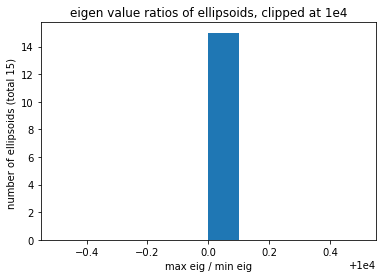

In [11]:
from pydrake.all import Hyperellipsoid
t_tot = np.concatenate(tuple(t_obj), axis=0)
q_tot = np.concatenate(tuple(q_obj))
cliques_tot = []
offset = 0
for i, c in enumerate(cliques_obj):
    if i>0:
        offset+= len(q_obj[i-1])
    cliques_tot += [cl + offset for cl in c] 

ells = []
for c in cliques_tot:
    clique_points = q_tot[c]
    ells +=  [Hyperellipsoid.MinimumVolumeCircumscribedEllipsoid(clique_points.T)]
min_eigs = []
max_eigs = []
ratios = []

for e in ells:
    eigs = np.linalg.eig(e.A()@e.A().T)[0]    
    if len(eigs) <7:
        maxe = 1e4
        ratio = 1e4
        mine =1 
    else:
        maxe = np.max(eigs)
        mine = np.min(eigs)
        ratio = maxe/mine
    ratios += [ratio]
    min_eigs +=[mine]
    max_eigs +=[maxe]

import matplotlib.pyplot as plt

plt.figure()
bins = plt.hist(np.clip(ratios,a_min = 0, a_max = 1e4))
plt.xlabel('max eig / min eig')
plt.ylabel(f"number of ellipsoids (total {len(ratios)}) ")
plt.title('eigen value ratios of ellipsoids, clipped at 1e4')
plt.show(block = False)
plt.pause(2)

In [13]:
from region_generation import SNOPT_IRIS_ellipsoid_parallel
from clique_covers import get_iris_metrics

q_min = plant.GetPositionLowerLimits()*1
q_max =  plant.GetPositionUpperLimits()*1
col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)

require_sample_point_is_contained = True
iteration_limit = 1
configuration_space_margin = 1.e-3
termination_threshold = -1
num_collision_infeasible_samples = 100
relative_termination_threshold = 0.02
estimate_coverage = get_coverage_estimator(sample_cfree, pts = 3000)

snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = require_sample_point_is_contained
snopt_iris_options.iteration_limit = iteration_limit
snopt_iris_options.configuration_space_margin = configuration_space_margin
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = termination_threshold
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_snopt_seed_guesses = 100
snopt_iris_options.num_collision_infeasible_samples = num_collision_infeasible_samples
snopt_iris_options.relative_termination_threshold = relative_termination_threshold
def col_hnd(pt):
    return 1- 1.0*checker.CheckConfigCollisionFree(pt)

iris_handle = partial(SNOPT_IRIS_ellipsoid_parallel,
                        region_obstacles = [],
                        logger = None, 
                        plant_builder = plant_builder,
                        snoptiris_options = snopt_iris_options,
                        estimate_coverage = estimate_coverage,
                        coverage_threshold = 1)

seed_points, metrics, _ = get_iris_metrics([q_tot[c] for c in cliques_tot], col_hnd)

if f"6dof_ur3_regions_{Npts}_{offset_size}_{seed}.pkl" in os.listdir('tmp'):
    with open(f"tmp/6dof_ur3_regions_{Npts}_{offset_size}_{seed}.pkl", 'rb') as f:
        d = pickle.load(f)
        regions_red = d['r']
        succs_sp = d['succs_sp']
        seed_points = d['sp']
        metrics = d['metrics']
else:
    regions_red, succs_sp, is_full = iris_handle(seed_points, metrics, [])
    with open(f"tmp/6dof_ur3_regions_{Npts}_{offset_size}_{seed}.pkl", 'wb') as f:
        pickle.dump({'r':regions_red, 'succs_sp':succs_sp, 'sp': seed_points, 'metrics': metrics}, f)

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking schunk0::collision against shelves::shelf_upper has already required 1000 counter-example searches; still searching...
INFO:drake: Finished checking schunk0::collision against shelves::shelf_upper after 1235 counter-example searches.


[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1
[SNOPT IRIS Worker]: Region:0 / 1


In [71]:
from utils import load_regions_from_experiment_dir
regions_c = load_regions_from_experiment_dir(
                    'logs_icra_paper/experiment_6dof_ur_shelf_10_1000_0.250greedy20230907140607')


Text(0.5, 1.0, 'connectivity')

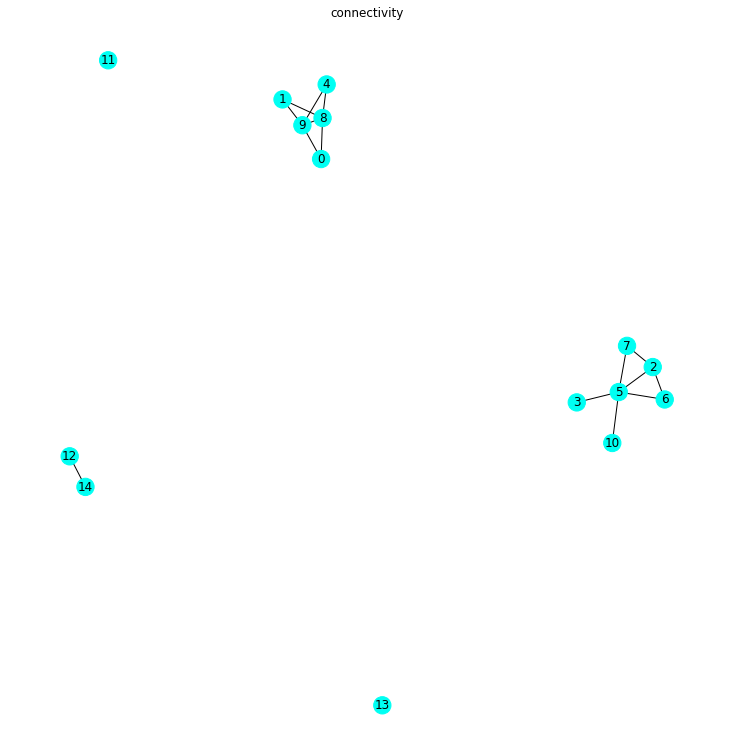

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
from visibility_utils import generate_distinct_colors
regs = regions_red#+regions_c
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)

for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[1])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regs], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [20]:
from visibility_utils import check_visibility_to_regions
q_obj_vis_idx = []
for i in range(len(q_obj)):
    visible_centers = check_visibility_to_regions(q_obj[i], regions_connected_component, checker)
    visibility_coverage = np.mean([1 if len(v) else 0 for v in visible_centers])
    print(visibility_coverage)
    q_obj_vis_idx.append(np.where([len(v) for v in visible_centers])[0])

0.315


In [16]:
from dijkstraspp import DijkstraSPP
# checker_dspp = SceneGraphCollisionChecker(model = diagram,#.Clone(), 
#                     robot_model_instances = robot_instances,
#                     distance_function_weights =  [1] * plant.num_positions(),
#                     #configuration_distance_function = _configuration_distance,
#                     edge_step_size = 0.01)
dspp = DijkstraSPP(regions_connected_component, checker, verbose=True)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 5
[DijkstraSPP] Pre-Building safe-adjacency matrix  0 / 5
[DijkstraSPP] Optimizing 7 point locations in safe sets
True


In [22]:
q_obj_vis = [q_obj[i][qidx] for i, qidx in enumerate(q_obj_vis_idx)]

In [23]:
from visualization_utils import get_shunk_plotter
plot_endeff_poses = get_shunk_plotter(plant, scene_graph, plant_context, diagram_context)
meshcat.Delete('/iris/shunk')
plot_endeff_poses(meshcat, np.concatenate(tuple(q_obj_vis),axis = 0)[::3])

{'body': <GeometryId value=79>, 'left_finger': <GeometryId value=85>, 'right_finger': <GeometryId value=91>}


In [25]:
q = scene_graph.get_query_output_port().Eval(scene_graph.GetMyContextFromRoot(diagram_context))
q.inspector()

In [80]:
import time
from visibility_utils import point_in_regions
centers = [r.ChebyshevCenter() for r in regions_connected_component]

# meshcat.SetProperty(f"/drake/visualizer/shunk", "visible", False)
objs = [0]

np.random.seed(131)
start = centers[1]
cur_time = 0
obj = 0
dist_ratio = []
cols = []
for _ in range(100):
    #nxt = vs.sample_in_regions() #
    nxt = q_obj_vis[obj][np.random.choice(len(q_obj_vis[obj]))]
    objidx = np.random.choice(len(objs))
    obj = objs[objidx]
    t1 = time.time()
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    t2 = time.time()
    print(f"plan time {t2-t1:.3f}")
    #wp2, dist2 = dspp2.solve(start, nxt, refine_path=True)
    #dist_ratio.append([dist, dist2])
    #print(dist)
    meshcat.Delete("/iris/points/traj/")
    dense_waypoints = densify_waypoints(wp, densify=100)
    dense_waypoints_plt = densify_waypoints(wp, densify=100)
    plot_endeff_traj(dense_waypoints_plt)
    print(len(dense_waypoints))
    for qa in dense_waypoints:
        #anim_endeff_traj(dense_waypoints_plt, animation, frame)
        #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
        showres(qa)
        #diagram_context.SetTime(cur_time)
        if not checker.CheckConfigCollisionFree(qa):
            print('PISAUDGFPIUDGSVP(&^%$(%08756987698))')
            cols.append(wp)
            
            break
            # for idx, r in enumerate(regions_connected_component):
            #     if point_in_regions(qa, [r]):
            #         print(f"collision in region {largest_con_comp[idx]}")
            #break
        #frame+=1
        time.sleep(0.001)
    start = nxt.copy()
    time.sleep(0.01)

[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 2.54 / 3.64 = 0.70
plan time 0.066
71
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] optimized distance/ start-distance = 1.77 / 2.06 = 0.86
plan time 0.068
53
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 2.10 / 2.21 = 0.95
plan time 0.057
39
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 6.13 / 6.62 = 0.93
plan time 0.406
147
[DijkstraSPP] Attempting visibility extension for start
[DijkstraSPP] optimized distance/ start-distance = 4.30 / 4.49 = 0.96
plan time 0.446
107
[DijkstraSPP] optimized distance/ start-distance = 1.13 / 1.31 = 0.86
plan time 0.017
34
plan time 0.046
26
[DijkstraSPP] Attempting visibility extension for end
[DijkstraSPP] optimized distance/ start-distance = 3.12 / 3.6

In [53]:
plot_endeff_traj(dense_waypoints_plt)

In [54]:
dense_waypoints_plt

[array([-0.31106737, -2.22842657,  1.39914027, -1.83138284, -1.86992961]),
 array([-0.29096073, -2.22149028,  1.38096017, -1.80494371, -1.84987874]),
 array([-0.27085408, -2.21455398,  1.36278007, -1.77850459, -1.82982787]),
 array([-0.25074744, -2.20761768,  1.34459998, -1.75206546, -1.809777  ]),
 array([-0.2306408 , -2.20068138,  1.32641988, -1.72562633, -1.78972613]),
 array([-0.21053416, -2.19374509,  1.30823978, -1.69918721, -1.76967526]),
 array([-0.19042752, -2.18680879,  1.29005968, -1.67274808, -1.74962439]),
 array([-0.17032088, -2.17987249,  1.27187958, -1.64630895, -1.72957352]),
 array([-0.15021424, -2.17293619,  1.25369948, -1.61986983, -1.70952265]),
 array([-0.1301076 , -2.16599989,  1.23551938, -1.5934307 , -1.68947178]),
 array([-0.11000095, -2.1590636 ,  1.21733928, -1.56699157, -1.66942091]),
 array([-0.11000095, -2.1590636 ,  1.21733928, -1.56699157, -1.66942091]),
 array([-0.11037163, -2.19197871,  1.22369343, -1.57790153, -1.70152568]),
 array([-0.11074231, -2.2

In [4]:
import pickle
import os

exp_name = "logs_icra_paper/experiment_5dof_ur_shelf_5_1000_0.250greedy20230907132112"#"5dof_ur_naive_shelf_20230819090833_1_1_0.050_0.100" #"experiment_5dof_ur_shelf_0_1000_0.100redu20230818072135"#"5DOf_ur_20230703162006_12_1000_0.050_0.140"
# poly_names = os.listdir("logs/"+exp_name+"/regions")
data_chkpts = os.listdir(exp_name+"/data")
# poly_names.sort()
itmax = np.max([int(x.replace('it_', '').replace('.pkl','')) for x in data_chkpts])
regions = []
# for p in poly_names:
#     with open("logs/"+exp_name+"/regions/"+p, 'rb') as f:
#         d = pickle.load(f)
#     regions.append(HPolyhedron(d['ra'], d['rb']))

with open(exp_name+"/data/"+f"it_{itmax}.pkl", 'rb') as f:
    d2 = pickle.load(f)

seed_points = d2['sp'][-1]
for rga, rgb in zip(d2['ra'], d2['rb']):
    for a,b in zip(rga, rgb):
        regions.append(HPolyhedron(a,b))


poi = []
#poi.append(np.array([-0.34743, -0.92743,  0.47257,  0.02257, -0.02743]))
poi.append(np.array([-1.62743, -1.32743,  2.57257, -1.22743, -0.02743]))
poi.append(np.array([-1.62743, -2.02743,  1.67257,  0.37257, -0.02743]))
poi.append(np.array([-1.72743, -1.82743, -2.02743,  0.67257, -0.02743]))
poi.append(np.array([-1.72743, -1.92743,  1.07257, -2.32743, -0.02743]))
#poi.append(np.array([-1.72743, -1.32743, -0.92743, -1.02743, -0.02743]))
#poi.append(np.array([-1.52743, -2.42743,  0.87257, -1.62743, -0.02743]))
#poi.append(np.array([-2.12743, -0.52743, -1.92743,  2.47257, -1.02743]))
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 10
snopt_iris_options.configuration_space_margin = 1.2e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 25
snopt_iris_options.relative_termination_threshold = 0.02
iris_handle = partial(SNOPT_IRIS_obstacles_simple, 
                      region_obstacles = [],
                      plant = plant, 
                      context = diagram_context,
                      snoptiris_options = snopt_iris_options,
                     )

# regions_poi=iris_handle(poi)
# with open('rpoi_shelf.pkl', 'wb') as f:
#     ra = [r.A() for r in regions_poi]
#     rb = [r.b() for r in regions_poi]
#     pickle.dump([ra, rb], f)
# with open('rpoi_shelf.pkl', 'rb') as f:
#     d = pickle.load(f)
#     regions_poi = [HPolyhedron(a,b) for a,b in zip(d[0], d[1])]

/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'connectivity')

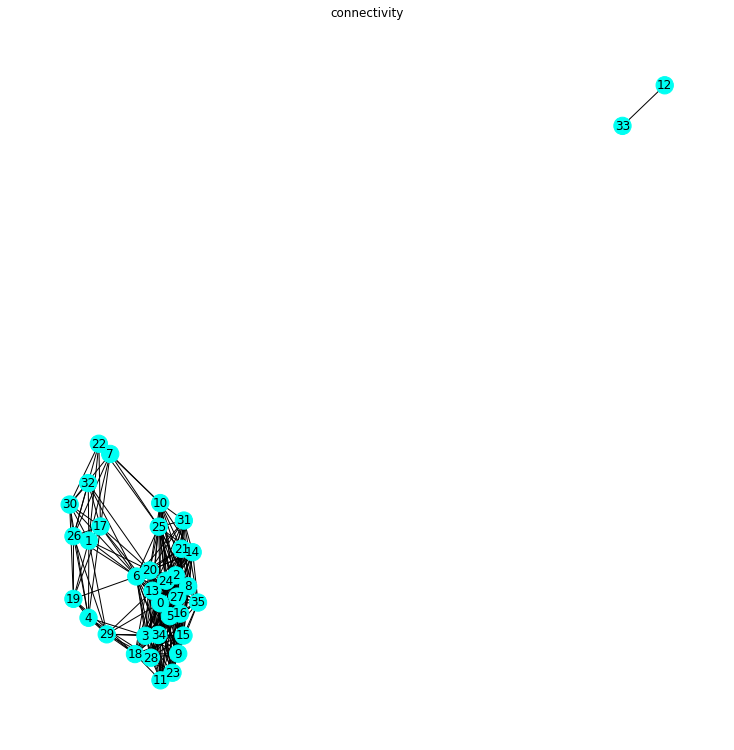

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from visibility_utils import generate_distinct_colors

regs = regions#+regions_poi
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)


for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
#for g, h in zip([regions, regions_poi], hues):
for g, h in zip([regions], hues):

    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [6]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions, conversion_dummy)
# import pickle
# with open(exp_name+"_dspp.pkl", 'rb') as f:
#     dspp = pickle.load(f)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 36
[DijkstraSPP] Pre-Building adjacency matrix  10 / 36
[DijkstraSPP] Pre-Building adjacency matrix  20 / 36
[DijkstraSPP] Pre-Building adjacency matrix  30 / 36
[DijkstraSPP] Pre-Building d-adjacency matrix  0 / 288


In [7]:
# import pickle
# dsppname = exp_name+"_dspp.pkl"
# with open(dsppname, 'wb') as f:
#     pickle.dump(dspp, f)

In [8]:
from pydrake.all import Mesh
a = Mesh('display_signs/5dof_sign_arxiv.gltf')
meshcat.SetObject('/instructionsign', a)
meshcat.SetTransform('/instructionsign',RigidTransform(
                            RotationMatrix.MakeZRotation(-np.pi/2)@RotationMatrix.MakeXRotation(-np.pi/2), 
                            np.array([0, 12 , 0])))

In [9]:
import time
centers = [r.ChebyshevCenter() for r in regions]
meshcat.SetProperty(f"/Grid", "visible", False)
meshcat.SetProperty(f"/drake/visualizer/shunk", "visible", False)

np.random.seed(10)
start = centers[0]

frame_time = 1/32.0
cur_time = 0
meshcat.StartRecording()
animation = meshcat.get_mutable_recording()
frame = 0
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt_ = sample_cfree(1, 1000, [])[0]
        if point_in_regions(nxt_, regions):
            nxt = nxt_.squeeze()
            break
        # nxt = centers[np.random.choice(len(centers))] #sample_cfree(1, 1000, [])[0].reshape(-1,1)#
        # #plot_endeff_pose(nxt, str(0))
        # if nxt.squeeze()[0] != start.squeeze()[0]:
        #     break
    print(f"start {start} next {nxt}")

    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    hide_traj("/iris/points/traj/",animation ,frame)
    #if dist >0:
    dense_waypoints = densify_waypoints(wp, densify=30)
    dense_waypoints_plt = densify_waypoints(wp, densify=90)
    #plot_endeff_traj(dense_waypoints_plt)
    print(len(dense_waypoints))
    for qa in dense_waypoints:
        anim_endeff_traj(dense_waypoints_plt, animation, frame)
        #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
        showres(qa)
        diagram_context.SetTime(cur_time)
        if col_func_handle_(qa):
            print('col')
            # for idx, r in enumerate(regions_connected_component):
            #     if point_in_regions(qa, [r]):
            #         print(f"collision in region {largest_con_comp[idx]}")
            #break
        cur_time+=frame_time
        frame+=1
        #time.sleep(0.003)
    start = nxt.copy()
        #time.sleep(0.01)
        
        # meshcat.Delete("/iris/points/traj/")
        
    

nxt = centers[0]
wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
print(dist)
hide_traj("/iris/points/traj/",animation ,frame)
if dist >0:
    dense_waypoints = densify_waypoints(wp, densify=30)
    dense_waypoints_plt = densify_waypoints(wp, densify=100)
    #plot_endeff_traj(dense_waypoints_plt)
    for qa in dense_waypoints:
        anim_endeff_traj(dense_waypoints_plt, animation, frame)
        #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
        showres(qa)
        diagram_context.SetTime(cur_time)
        if col_func_handle_(qa):
            print('col')
            # for idx, r in enumerate(regions_connected_component):
            #     if point_in_regions(qa, [r]):
            #         print(f"collision in region {largest_con_comp[idx]}")
            #break
        cur_time+=frame_time
        frame+=1
        #time.sleep(0.003)

from pydrake.all import MeshcatAnimation
meshcat.StopRecording()
animation.set_autoplay(True)
#animation.set_loop_mode(MeshcatAnimation.LoopMode(2))
meshcat.PublishRecording()
with open("static_htmls/5DOFUR5_arxiv.html", "w+") as f:
    f.write(meshcat.StaticHtml())

start [ 1.23593407 -1.28998618 -1.30240091 -1.03184387 -0.30360355] next [ 1.53428209 -2.71008388  0.75576296  1.40695281 -0.00844265]
[DijkstraSPP] optimized distance/ start-distance = 3.52 / 3.52 = 1.00
3.51803591997863
11
start [ 1.53428209 -2.71008388  0.75576296  1.40695281 -0.00844265] next [-1.55623831 -1.70741427  1.47326647 -1.87113414 -2.32788351]
[DijkstraSPP] optimized distance/ start-distance = 6.66 / 8.20 = 0.81
6.657535279464993
69
start [-1.55623831 -1.70741427  1.47326647 -1.87113414 -2.32788351] next [ 0.24058273 -2.02348071 -0.71624113  0.98470239 -0.32892565]
[DijkstraSPP] optimized distance/ start-distance = 4.69 / 7.37 = 0.64
4.685481552408123
37
start [ 0.24058273 -2.02348071 -0.71624113  0.98470239 -0.32892565] next [-0.34152433 -1.88758238  0.03946322  1.80410531 -2.31789181]
[DijkstraSPP] optimized distance/ start-distance = 2.36 / 2.36 = 1.00
2.357077335732448
16
start [-0.34152433 -1.88758238  0.03946322  1.80410531 -2.31789181] next [ 0.32399789 -0.64966729